In [1]:

import pandas as pd
import numpy as np
from google.colab import data_table
from google.colab import drive

ff = pd.read_csv('World Energy Overview.csv',sep=",",)


In [2]:
# Display data frame and check the data types
#display(ff)
#ff.dtypes

In [3]:
ff.rename(columns={'Total Fossil Fuels Consumption':'Total_Fossil_Fuels_Consumption'},inplace = True)

In [4]:
# convert data to time series
ff['Date']= pd.to_datetime(ff['Date'], format='%Y-%m-%d')

#display(ff)
ff_series = pd.Series(ff['Total_Fossil_Fuels_Consumption'].values, index=ff.Date, name='Total_Fossil_Fuels_Consumption')

In [5]:
#ff_series

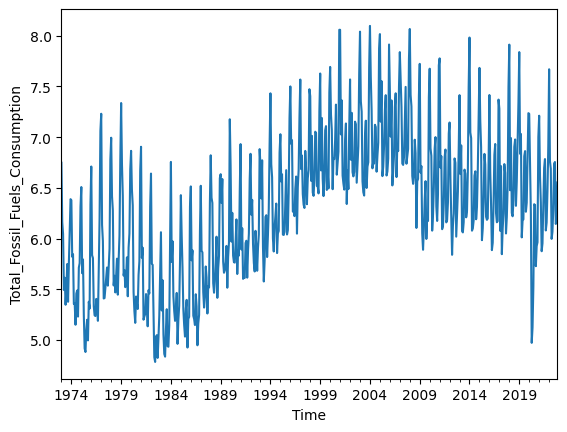

In [6]:
# Plot the time series
# Have you observed any trend and seasonality in the plot?
import matplotlib.pylab as plt
ax = ff_series.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Total_Fossil_Fuels_Consumption')
plt.show()

In [7]:
start_date = '1984-01-01'
end_date = '2004-12-31'
fs = ff_series[start_date:end_date]

In [8]:
#fs

In [9]:
# Data partition for the time series data
# Keep the last 3 years data as the validation dataset
nValid = 36
nTrain = len(fs) - nValid
train_ts = fs[:nTrain]
valid_ts = fs[nTrain:]

# Model 1

In [10]:
# Model 1: A linear trend time series model
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
# Add a trend term to the time series
ts_df = tsatools.add_trend(fs,trend='ct')
# Add a month variable to the time series
ts_df['Month']=ts_df.index.month
nValid = 36
nTrain = len(fs) - nValid
train_df = ts_df[:nTrain]
valid_df = ts_df[nTrain:]
fs_lm = sm.ols(formula='Total_Fossil_Fuels_Consumption ~ trend',data=train_df).fit()

In [11]:
# Display the linear regression model result
fs_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Total_Fossil_Fuels_Consumption   R-squared:                       0.546
Model:                                        OLS   Adj. R-squared:                  0.544
Method:                             Least Squares   F-statistic:                     257.6
Date:                            Fri, 15 Mar 2024   Prob (F-statistic):           1.40e-38
Time:                                    18:28:59   Log-Likelihood:                -126.06
No. Observations:                             216   AIC:                             256.1
Df Residuals:                                 214   BIC:                             262.9
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4138      0.060     90.980      0.000       5.297       5.531
trend          0.0076      0.000     16.051      0.000       0.007       0.009
==============================================================================
Omnibus:                       21.865   Durbin-Watson:                   0.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.292
Skew:                           0.855   Prob(JB):                     1.95e-06
Kurtosis:                       3.008   Cond. No.                         251.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Evaluate Model1 performance
#! pip install dmba
from dmba import regressionSummary
predict_lm = fs_lm.predict(valid_df)
regressionSummary(valid_ts,predict_lm)

Colab environment detected.

Regression statistics

                      Mean Error (ME) : -0.1712
       Root Mean Squared Error (RMSE) : 0.4806
            Mean Absolute Error (MAE) : 0.4182
          Mean Percentage Error (MPE) : -2.8289
Mean Absolute Percentage Error (MAPE) : 6.0043


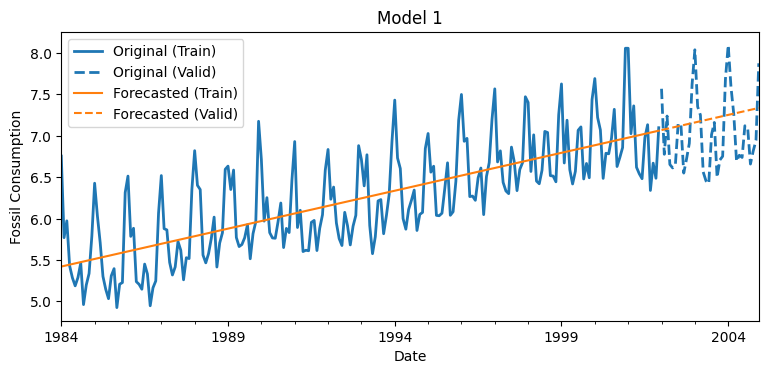

In [13]:
# Visulize Model1
# Blue line for the original time series
# Orange line for the forecasted time series
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3.75))
train_df.plot(y='Total_Fossil_Fuels_Consumption', ax=ax, color='C0', linewidth=2, label='Original (Train)')
valid_df.plot(y='Total_Fossil_Fuels_Consumption', ax=ax, color='C0', linewidth=2, linestyle='dashed', label='Original (Valid)')
fs_lm.predict(train_df).plot(color='C1', label='Forecasted (Train)')
fs_lm.predict(valid_df).plot(color='C1', linestyle='dashed', label='Forecasted (Valid)')
ax.set_title("Model 1")
ax.set_ylabel("Fossil Consumption")
ax.legend()
plt.show()

In [14]:
pred_train_lm = fs_lm.predict(train_df)
regressionSummary(train_ts,pred_train_lm)


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.4337
            Mean Absolute Error (MAE) : 0.3535
          Mean Percentage Error (MPE) : -0.4732
Mean Absolute Percentage Error (MAPE) : 5.6235


In [15]:
from sklearn.metrics import r2_score, mean_squared_error
print('Model 1 statistics:')
print()
print('train:')
print(f'R-squared: {r2_score(train_ts,pred_train_lm)}')
print(f'RMSE: {mean_squared_error(train_ts,pred_train_lm,squared=False)}')
print()
print('valid:')
print(f'R-squared: {r2_score(valid_ts,predict_lm)}')
print(f'RMSE: {mean_squared_error(valid_ts,predict_lm,squared=False)}')


Model 1 statistics:

train:
R-squared: 0.5462464770268087
RMSE: 0.43373616355317857

valid:
R-squared: -0.14650387708106205
RMSE: 0.4806103042434507


# Model 2

In [16]:
# Model 2: An additive seasonality model
fs_lm_season = sm.ols(formula='Total_Fossil_Fuels_Consumption~C(Month)',data=train_df).fit()
fs_lm_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Total_Fossil_Fuels_Consumption   R-squared:                       0.369
Model:                                        OLS   Adj. R-squared:                  0.335
Method:                             Least Squares   F-statistic:                     10.86
Date:                            Fri, 15 Mar 2024   Prob (F-statistic):           1.08e-15
Time:                                    18:29:00   Log-Likelihood:                -161.61
No. Observations:                             216   AIC:                             347.2
Df Residuals:                                 204   BIC:                             387.7
Df Model:                                      11                                         
Covariance Type:                        nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.0655      0.124     56.973      0.000       6.821       7.310
C(Month)[T.2]     -0.6699      0.175     -3.820      0.000      -1.016      -0.324
C(Month)[T.3]     -0.5356      0.175     -3.054      0.003      -0.881      -0.190
C(Month)[T.4]     -1.1226      0.175     -6.401      0.000      -1.468      -0.777
C(Month)[T.5]     -1.2046      0.175     -6.868      0.000      -1.550      -0.859
C(Month)[T.6]     -1.1762      0.175     -6.707      0.000      -1.522      -0.830
C(Month)[T.7]     -0.8699      0.175     -4.960      0.000      -1.216      -0.524
C(Month)[T.8]     -0.7882      0.175     -4.494      0.000      -1.134      -0.442
C(Month)[T.9]     -1.2851      0.175     -7.327      0.000      -1.631      -0.939
C(Month)[T.10]    -1.0566      0.175     -6.025      0.000      -1.402      -0.711
C(Month)[T.11]    -0.9820      0.175     -5.599      0.000      -1.328      -0.636
C(Month)[T.12]    -0.1926      0.175     -1.098      0.273      -0.538       0.153
==============================================================================
Omnibus:                       29.221   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.118
Skew:                           0.044   Prob(JB):                       0.0173
Kurtosis:                       2.054   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Evaluate Model2 performance
predict_lm_season = fs_lm_season.predict(valid_df)
regressionSummary(valid_ts, predict_lm_season)


Regression statistics

                      Mean Error (ME) : 0.7905
       Root Mean Squared Error (RMSE) : 0.8055
            Mean Absolute Error (MAE) : 0.7905
          Mean Percentage Error (MPE) : 11.2141
Mean Absolute Percentage Error (MAPE) : 11.2141


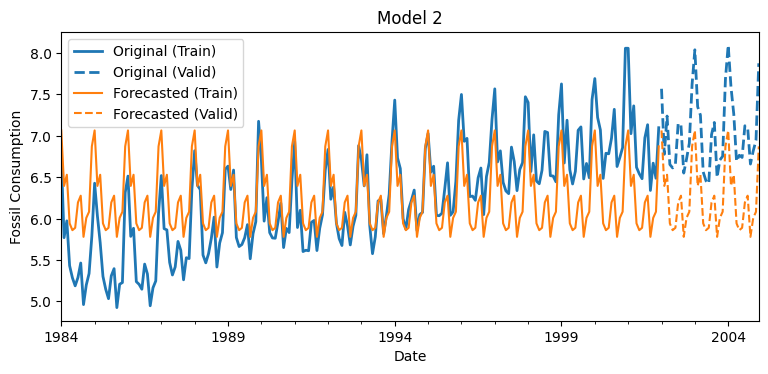

In [18]:
# Visulize Model2
# Blue line for the original time series
# Orange line for the forecasted time series
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3.75))
train_df.plot(y='Total_Fossil_Fuels_Consumption', ax=ax, color='C0', linewidth=2, label='Original (Train)')
valid_df.plot(y='Total_Fossil_Fuels_Consumption', ax=ax, color='C0', linewidth=2, linestyle='dashed', label='Original (Valid)')
fs_lm_season.predict(train_df).plot(color='C1', label='Forecasted (Train)')
fs_lm_season.predict(valid_df).plot(color='C1', linestyle='dashed', label='Forecasted (Valid)')
ax.set_title("Model 2")
ax.set_ylabel("Fossil Consumption")
ax.legend()

plt.show()

In [19]:
pred_train_lm_season = fs_lm_season.predict(train_df)
regressionSummary(train_ts,pred_train_lm_season)


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.5113
            Mean Absolute Error (MAE) : 0.4318
          Mean Percentage Error (MPE) : -0.6865
Mean Absolute Percentage Error (MAPE) : 7.0081


In [20]:
from sklearn.metrics import r2_score, mean_squared_error
print('Model 2 statistics:')
print()
print('train:')
print(f'R-squared: {r2_score(train_ts,pred_train_lm_season)}')
print(f'RMSE: {mean_squared_error(train_ts,pred_train_lm_season,squared=False)}')
print()
print('valid:')
print(f'R-squared: {r2_score(valid_ts,predict_lm_season)}')
print(f'RMSE: {mean_squared_error(valid_ts,predict_lm_season,squared=False)}')


Model 2 statistics:

train:
R-squared: 0.36937496743977094
RMSE: 0.5113299505856986

valid:
R-squared: -2.2205235785705932
RMSE: 0.8055055841720289


# Model 3

In [21]:
# Model 3: A model with linear trend and seasonality
modelfomula = 'Total_Fossil_Fuels_Consumption ~ trend + C(Month)'
fs_lm_trendseason = sm.ols(formula=modelfomula, data=train_df).fit()
fs_lm_trendseason.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Total_Fossil_Fuels_Consumption   R-squared:                       0.929
Model:                                        OLS   Adj. R-squared:                  0.925
Method:                             Least Squares   F-statistic:                     222.8
Date:                            Fri, 15 Mar 2024   Prob (F-statistic):          1.00e-109
Time:                                    18:29:02   Log-Likelihood:                 74.903
No. Observations:                             216   AIC:                            -123.8
Df Residuals:                                 203   BIC:                            -79.93
Df Model:                                      12                                         
Covariance Type:                        nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.2683      0.046    135.999      0.000       6.177       6.359
C(Month)[T.2]     -0.6776      0.059    -11.521      0.000      -0.794      -0.562
C(Month)[T.3]     -0.5511      0.059     -9.369      0.000      -0.667      -0.435
C(Month)[T.4]     -1.1459      0.059    -19.480      0.000      -1.262      -1.030
C(Month)[T.5]     -1.2356      0.059    -21.005      0.000      -1.352      -1.120
C(Month)[T.6]     -1.2149      0.059    -20.653      0.000      -1.331      -1.099
C(Month)[T.7]     -0.9164      0.059    -15.576      0.000      -1.032      -0.800
C(Month)[T.8]     -0.8424      0.059    -14.317      0.000      -0.958      -0.726
C(Month)[T.9]     -1.3470      0.059    -22.893      0.000      -1.463      -1.231
C(Month)[T.10]    -1.1263      0.059    -19.140      0.000      -1.242      -1.010
C(Month)[T.11]    -1.0594      0.059    -18.002      0.000      -1.175      -0.943
C(Month)[T.12]    -0.2778      0.059     -4.720      0.000      -0.394      -0.162
trend              0.0077      0.000     40.134      0.000       0.007       0.008
==============================================================================
Omnibus:                        7.255   Durbin-Watson:                   1.024
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                9.360
Skew:                           0.238   Prob(JB):                      0.00928
Kurtosis:                       3.902   Cond. No.                     1.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# Evaluate Model3 performance
predict_lm_trendseason = fs_lm_trendseason.predict(valid_df)
regressionSummary(valid_ts,predict_lm_trendseason)


Regression statistics

                      Mean Error (ME) : -0.1847
       Root Mean Squared Error (RMSE) : 0.2305
            Mean Absolute Error (MAE) : 0.1959
          Mean Percentage Error (MPE) : -2.6976
Mean Absolute Percentage Error (MAPE) : 2.8476


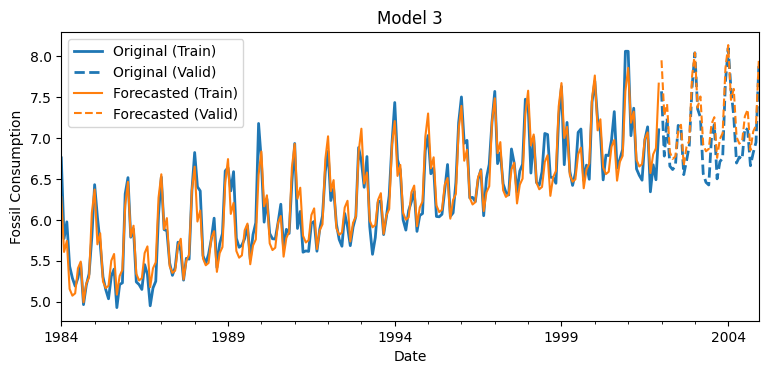

In [23]:
# Visulize Model3
# Blue line for the original time series
# Orange line for the forecasted time series
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3.75))
train_df.plot(y='Total_Fossil_Fuels_Consumption', ax=ax, color='C0', linewidth=2, label='Original (Train)')
valid_df.plot(y='Total_Fossil_Fuels_Consumption', ax=ax, color='C0', linewidth=2, linestyle='dashed', label='Original (Valid)')
fs_lm_trendseason.predict(train_df).plot(color='C1', label='Forecasted (Train)')
fs_lm_trendseason.predict(valid_df).plot(color='C1', linestyle='dashed', label='Forecasted (Valid)')
ax.set_title("Model 3")
ax.set_ylabel("Fossil Consumption")
ax.legend()

plt.show()

In [24]:
predict_lm_trendseason_train = fs_lm_trendseason.predict(train_df)
regressionSummary(train_ts,predict_lm_trendseason_train)


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.1711
            Mean Absolute Error (MAE) : 0.1325
          Mean Percentage Error (MPE) : -0.0743
Mean Absolute Percentage Error (MAPE) : 2.1111


In [25]:
from sklearn.metrics import r2_score, mean_squared_error
print('Model 3 statistics:')
print()
print('train:')
print(f'R-squared: {r2_score(train_ts,predict_lm_trendseason_train)}')
print(f'RMSE: {mean_squared_error(train_ts,predict_lm_trendseason_train,squared=False)}')
print()
print('valid:')
print(f'R-squared: {r2_score(valid_ts,predict_lm_trendseason)}')
print(f'RMSE: {mean_squared_error(valid_ts,predict_lm_trendseason,squared=False)}')

Model 3 statistics:

train:
R-squared: 0.9294187704906427
RMSE: 0.1710646363465398

valid:
R-squared: 0.7363979791008061
RMSE: 0.2304515755615945


# Model 4

In [26]:
# Model 4: Simple exponential smoothing
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.h
from statsmodels.tsa.api import SimpleExpSmoothing
SES = SimpleExpSmoothing(train_ts, initialization_method='estimated').fit()
predict_SES = SES.forecast(len(valid_ts))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [27]:
# Alpha and initial level are estimated by minimizing SSE
# Check the optimal model parameters
SES.model.params

{'smoothing_level': 0.8493475931931768,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 6.609745122290298,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [28]:
# Evaluate Model4 performance
regressionSummary(valid_ts,predict_SES)


Regression statistics

                      Mean Error (ME) : 0.0227
       Root Mean Squared Error (RMSE) : 0.4494
            Mean Absolute Error (MAE) : 0.3715
          Mean Percentage Error (MPE) : -0.0676
Mean Absolute Percentage Error (MAPE) : 5.2006


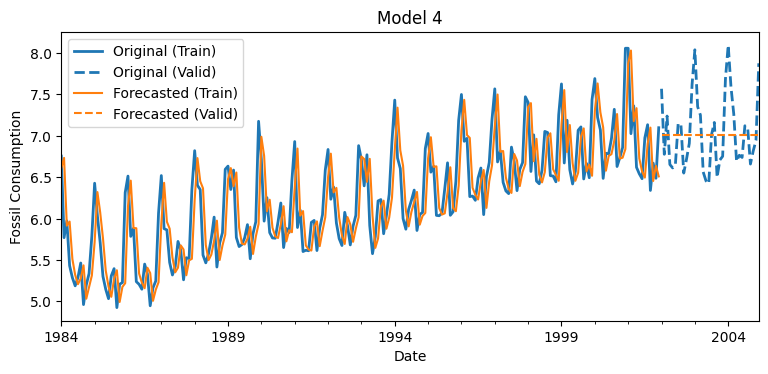

In [29]:
# Visualize Model 4
# Blue line for the original time series
# Orange line for the forecasted time series
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 3.75))

train_ts.plot(ax=ax, color='C0', linewidth=2, label='Original (Train)')
valid_ts.plot(ax=ax, color='C0', linewidth=2, linestyle='dashed', label='Original (Valid)')


# Forecasted training line
SES.fittedvalues.plot(ax=ax, color='C1', label='Forecasted (Train)')
predict_SES.plot(ax=ax, color='C1', linestyle='dashed', label='Forecasted (Valid)')
ax.set_ylabel("Fossil Consumption")
ax.set_title("Model 4")

ax.legend()

In [30]:
predict_SES_train = SES.forecast(len(train_ts))
regressionSummary(train_ts,predict_SES_train)


Regression statistics

                      Mean Error (ME) : -0.7678
       Root Mean Squared Error (RMSE) : 1.0021
            Mean Absolute Error (MAE) : 0.8468
          Mean Percentage Error (MPE) : -13.5030
Mean Absolute Percentage Error (MAPE) : 14.5472


In [31]:
from sklearn.metrics import r2_score, mean_squared_error
print('Model 4 statistics:')
print()
print('train:')
print(f'R-squared: {r2_score(train_ts,predict_SES_train)}')
print(f'RMSE: {mean_squared_error(train_ts,predict_SES_train,squared=False)}')
print()
print('valid:')
print(f'R-squared: {r2_score(valid_ts,predict_SES)}')
print(f'RMSE: {mean_squared_error(valid_ts,predict_SES,squared=False)}')

Model 4 statistics:

train:
R-squared: -1.4219497117453925
RMSE: 1.0020702978489413

valid:
R-squared: -0.002555425893189245
RMSE: 0.44942736227258684


# ARIMA

In [32]:
# Dickey-Fuller Test to verify whether a time-series is stationary
# p-vlaue: insignificance indicating non-stationary
# Test Statistic > Critical Value: non-stationary

from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(fs,autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'p-value', '#lags used', 'Number of observations Used'])

for key , value in dftest[4].items(): dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.826077
p-value                          0.811342
#lags used                      14.000000
Number of observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


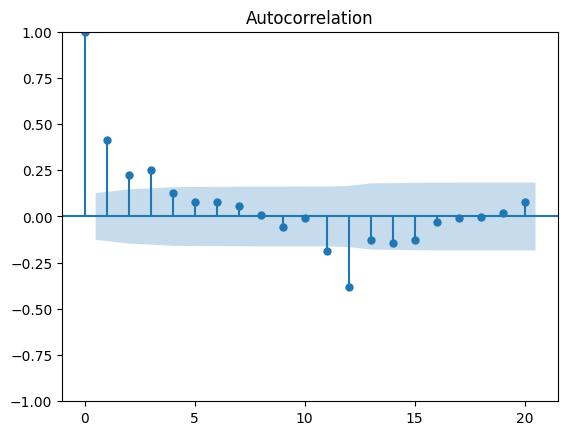

In [33]:
# Plot ACF to check potential seasonality
# ACF: autocorrelation factor
import statsmodels.tsa.api as smt
fs_diff = fs.diff(periods=12)
fs_diff.dropna(inplace=True)
smt.graphics.plot_acf(fs_diff, lags=20, alpha= 0.05)
plt.show()

In [34]:
# To identify the best fit ARIMA model
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all possible combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all possible combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]
# Display p, d and q combinations
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [35]:
import sys
# Specify to ignore warning messages
import warnings
warnings.filterwarnings("ignore")
# Set up the initial values
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [36]:
import statsmodels.api as sm
# Using loops to search for the best ARIMA model
# Choose the best ARIMA model based on minimum AIC values
# AIC: to balance the model between goodness-of-fit and number of parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = temp_model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal

        except:
            continue
    print("Just tried SARIMAX{}x{}12 model - AIC:{} ... ".format(param, param_seasonal, results.aic))
    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Just tried SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 model - AIC:-6.816976779977095 ... 
Best SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 model - AIC:-8.784467981302358
Just tried SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 model - AIC:-56.483180412898605 ... 
Best SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 model - AIC:-57.76421101304809
Just tried SARIMAX(0, 1, 0)x(1, 1, 1, 12)12 model - AIC:-84.84096354474813 ... 
Best SARIMAX(0, 1, 0)x(0, 1, 1, 12)12 model - AIC:-86.83921226219326
Just tried SARIMAX(0, 1, 1)x(1, 1, 1, 12)12 model - AIC:-125.76881477178276 ... 
Best SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 model - AIC:-127.60774584292656
Just tried SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 model - AIC:-92.27840344372584 ... 
Best SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 model - AIC:-127.60774584292656
Just tried SARIMAX(1, 0, 1)x(1, 1, 1, 12)12 model - AIC:-127.3262889892016 ... 
Best SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 model - AIC:-127.60774584292656
Just tried SARIMAX(1, 1, 0)x(1, 1, 1, 12)12 model - AIC:-100.3868359289136 ... 
Best SARIMAX(0, 1, 1)

In [37]:
import statsmodels.api as sm
# Display best ARIMA model detailed results
best_model = sm.tsa.statespace.SARIMAX(train_ts,
                                       order=(1,1,1),
                                       seasonal_order=(0,1,1,12),
                                       enforce_stationarity=True,
                                       enforce_invertibility=True)

best_results = best_model.fit()

In [38]:
# Display coefficients for the AR & MA components
# sigma square: variance of residuals
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:     Total_Fossil_Fuels_Consumption   No. Observations:                  216
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  70.905
Date:                            Fri, 15 Mar 2024   AIC                           -133.811
Time:                                    18:30:10   BIC                           -120.558
Sample:                                01-31-1984   HQIC                          -128.449
                                     - 12-31-2001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3033      0.094      3.216      0.001       0.118       0.488
ma.L1         -0.8438      0.067   

In [39]:
# Forecast using the best ARIMA model
# alpha=0.05, 95% confidence intervals
pred = best_results.get_forecast(steps=36,alpha=0.05)
# Evaluate the best ARIMA model performance
#! pip install dmba
from dmba import regressionSummary
regressionSummary(valid_ts, pred.predicted_mean)



Regression statistics

                      Mean Error (ME) : 0.1086
       Root Mean Squared Error (RMSE) : 0.1741
            Mean Absolute Error (MAE) : 0.1341
          Mean Percentage Error (MPE) : 1.4775
Mean Absolute Percentage Error (MAPE) : 1.8653


In [40]:
# Visualize ARIMA forecast
# Blue line for the original time series
# Orange line for the forecasted time series
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 3.75))

# Plot the original time series
#train_ts.plot(ax=ax, color='C0', linewidth=2, label='Original (Train)')
#valid_ts.plot(ax=ax, color='C0', linewidth=2, linestyle='dashed', label='Original (Valid)')

# Plot the forecasted values
#pred.predicted_mean.plot(ax=ax, color='C1', linestyle='dashed', label='Forecasted (Valid)')

#ax.set_ylabel("Fossil Consumption")
#ax.set_title("ARIMA Forecast")

#ax.legend()
#plt.show()

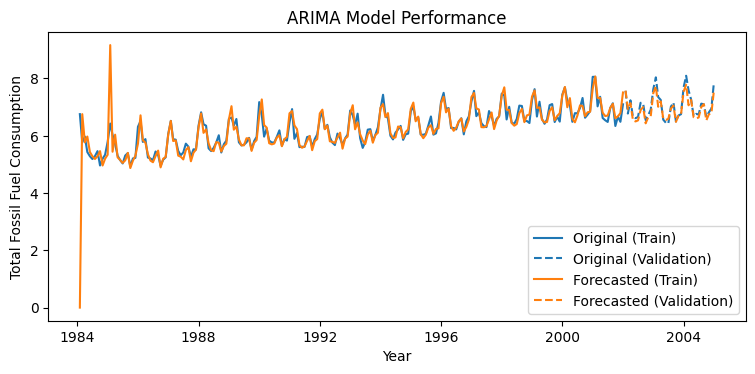

In [41]:
# Visualize ARIMA forecast
# Blue line for the original time series
# Orange line for the forecasted time serie
fig, ax = plt.subplots(figsize=(9, 3.75))

# Plot the original time series from the dataframes
ax.plot(train_ts.index, train_ts, color='C0', label='Original (Train)')
ax.plot(valid_ts.index, valid_ts, color='C0', linestyle='dashed', label='Original (Validation)')

# Plot the fitted values for the training set
if hasattr(best_results, 'fittedvalues'):
    ax.plot(train_ts.index, best_results.fittedvalues, color='C1', label='Forecasted (Train)')
else:
    print("Fitted values not available")

# Plot the forecasted values for the validation set
if hasattr(pred, 'predicted_mean'):
    ax.plot(valid_ts.index, pred.predicted_mean, color='C1', linestyle='dashed', label='Forecasted (Validation)')
else:
    print("Predicted mean not available")

# Set labels and title
ax.set_ylabel('Total Fossil Fuel Consumption')
ax.set_xlabel('Year')
ax.set_title('ARIMA Model Performance')
ax.legend()

# Show the plot
plt.show()